# Анализ программы лояльности

## Описание данных

Нам были предоставлены данные о покупках клиентов магазина в разбивке по участию в программе лояльности, а также таблица с ценами товаров.

### План по выполнению проекта:
1. Загрузить данные и изучить их
1. Предобработать данные для анализа
    - Заменить названия столбцов
    - Проверить данные на пропуски и дубликаты
    - Изменить типы данных, если нужно
1. Провести исследовательский анализ данных
    - Провести анализ пропусков
    - Провести анализ выбросов и аномальных значений
    - В разбивке по участию в программе лояльности посчитать средний чек и количество товаров в нём
    - Построить графики распределения для лояльных клиентов и обычных
1. Проверить гипотезы
    - Средний чек лояльных пользователей выше, чем у тех, кто в программе лояльности не участвует
    - Лояльные пользователи в среднем покупают больше товаров за раз
1. Написать общий вывод и дать рекомендации по развитию программы лояльности

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.figure_factory as ff
from IPython.display import display
from scipy import stats as st
warnings.filterwarnings('ignore')

### Шаг 1. Знакомство с данными 

In [2]:
retail = pd.read_csv('retail_dataset.csv')
products = pd.read_csv('product_codes.csv')

In [3]:
for df in [retail, products]:
    display(df.info())
    display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


None

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
50903,538881,82583,0,2016-12-14 15:54:00,NaN,Shop 0,0.0
52995,537399,20986,2,2016-12-06 14:31:00,18709.0,Shop 0,0.0
1544,544073,22960,47,2017-02-15 14:44:00,20614.0,Shop 16,0.0
39169,543382,21068,5,2017-02-07 16:21:00,19709.0,Shop 0,0.0
4578,537643,22469,4,2016-12-07 15:34:00,NaN,Shop 0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


None

,productID,price_per_one
1035,22719,2.51
735,22049,0.42
7804,22630,4.13
8116,90101,2.48
1123,71459,1.69


**Вывод шага 1:**

Первый взгляд на данные сделан:
- нужно привести названия столбцов к единому виду
- проверить данные на дубликаты
- нужно заменить тип данных в столбце с датой покупки
- нужно задуматься об оптимизации памяти: привести к другому типу столбцы `ShopID` и `loyalty_program`
- пропуски есть лишь в столбце с айди клиента, этих пропусков достаточно много, нужно проанализировать их

### Шаг 2. Предобработка данных

#### 2.1 Замена названий столбцов

In [4]:
retail = retail.rename(columns = {'purchaseid': 'purchase_id', 'item_ID': 'item_id',
                                  'Quantity': 'quantity', 'purchasedate': 'purchase_date',
                                  'CustomerID': 'customer_id', 'ShopID': 'shop_id', 
                                  'loyalty_program': 'loyal'})

In [5]:
products = products.rename(columns = {'productID': 'item_id'})

#### 2.2 Поиск дубликатов

In [6]:
for df in [retail, products]:
    display(df[df.duplicated()])
    print('Доля дубликатов: {:.2%}'.format(df.duplicated().mean()))

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyal
5345,537265,21499,24,2016-12-06 11:26:00,21598.0,Shop 0,0.0
5863,540803,21485,0,2017-01-11 12:30:00,20348.0,Shop 0,0.0
6893,540524,21326,11,2017-01-09 12:53:00,22414.0,Shop 0,1.0
7821,537192,22585,0,2016-12-05 13:42:00,22081.0,Shop 0,1.0
10806,537772,22080,4,2016-12-08 12:35:00,23722.0,Shop 0,1.0
...,...,...,...,...,...,...,...
105164,542224,22178,5,2017-01-26 12:45:00,23567.0,Shop 0,1.0
105173,544153,82552,1,2017-02-16 12:11:00,21035.0,Shop 0,0.0
105178,540839,21123,0,2017-01-11 15:42:00,22470.0,Shop 0,1.0
105229,543277,21533,0,2017-02-06 14:33:00,21487.0,Shop 0,0.0


Доля дубликатов: 0.98%


,item_id,price_per_one


Доля дубликатов: 0.00%


Дубликаты есть только в таблице `retail` и их меньше 1%. Вряд ли удаление сильно скажется на анализе. Но перед этим попробуем предположить причину и последствия такого дублирования.

In [7]:
retail[retail['purchase_id'] == '542224'].sort_values(by = 'item_id')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyal
7490,542224,17012D,0,2017-01-26 12:45:00,23567.0,Shop 0,1.0
57160,542224,17012D,0,2017-01-26 12:45:00,23567.0,Shop 0,1.0
76879,542224,21034,0,2017-01-26 12:45:00,23567.0,Shop 0,1.0
6475,542224,22178,5,2017-01-26 12:45:00,23567.0,Shop 0,1.0
105164,542224,22178,5,2017-01-26 12:45:00,23567.0,Shop 0,1.0
23288,542224,22371,0,2017-01-26 12:45:00,23567.0,Shop 0,1.0
80023,542224,22372,0,2017-01-26 12:45:00,23567.0,Shop 0,1.0
42673,542224,22374,0,2017-01-26 12:45:00,23567.0,Shop 0,1.0
49501,542224,40016,23,2017-01-26 12:45:00,23567.0,Shop 0,1.0
29296,542224,47566,2,2017-01-26 12:45:00,23567.0,Shop 0,1.0


В одной покупке продублировались 2 строчки:
- товар 17012D в количестве 0 штук
- товар 22178 в количестве 5 штук

Первый товар возможно был по акции, и он не влияет на средний чек или количество товаров в чеке. 

Другой товар мог продублировать случайно, тогда это может повлиять на эти метрики. Ведь есть разница между 5 штуками или 10. Или это случилось из-за кассира.

Решение: удалить дубликаты, так как их немного, но они могут исказить данные.

In [8]:
retail = retail.drop_duplicates()

#### 2.3 Замена типов данных

Для даты.

In [9]:
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'], format = '%Y-%m-%d %H:%M:%S')

Для `loyalty_program`, так как тип значения 0 и 1 лучше записывать в тип `bool`.

In [10]:
retail['loyal'] = retail['loyal'].astype('bool')

Для `shop_id`, чтобы оставить только номер магазина и преобразовать к типу `int`.

In [11]:
retail['shop_id'] = retail['shop_id'].str.extract('(\d+)').astype('int8')

In [12]:
retail.dtypes

purchase_id              object
item_id                  object
quantity                  int64
purchase_date    datetime64[ns]
customer_id             float64
shop_id                    int8
loyal                      bool
dtype: object

**Вывод шага 2:**

Произведена предобработка данных: удалены дубликаты, изменены названия столбцов и типы данных.

### Шаг 3. EDA 

#### 3.1 Анализ пропусков

In [13]:
retail.isna().mean()

purchase_id      0.000000
item_id          0.000000
quantity         0.000000
purchase_date    0.000000
customer_id      0.346571
shop_id          0.000000
loyal            0.000000
dtype: float64

Почти 35% пользователей не имеют свой айди. Посмотрим, имеют ли эти анонимы какие-то общие черты.

In [14]:
anon = retail[retail['customer_id'].isna()]

In [15]:
for col in anon.columns:
    print(col)
    print(anon[col].value_counts())
    print()

purchase_id
537434    675
538071    651
538349    613
537638    601
537237    597
         ... 
542415      1
540696      1
537008      1
538139      1
544773      1
Name: purchase_id, Length: 748, dtype: int64

item_id
DOT         175
85099B      112
22197       107
22379        94
22469        93
           ... 
21629         1
21096         1
85044         1
20835         1
DCGS0070      1
Name: item_id, Length: 2663, dtype: int64

quantity
 0      19880
 1       6525
 2       2851
 3       1732
 4       1031
        ...  
 107        1
 171        1
 459        1
-43         1
 959        1
Name: quantity, Length: 209, dtype: int64

purchase_date
2016-12-06 16:57:00    675
2016-12-09 14:09:00    651
2016-12-10 14:59:00    614
2016-12-07 15:28:00    601
2016-12-06 09:58:00    597
                      ... 
2017-02-18 13:54:00      1
2017-01-27 14:54:00      1
2017-01-05 09:55:00      1
2017-02-04 09:52:00      1
2017-01-28 12:03:00      1
Name: purchase_date, Length: 629, dtype: int

Ага, все эти пользователи не участвуют в программе лояльности. Посмотрим, насколько изменится доля лояльных клиентов, если мы удалим пропуски.

In [16]:
print('Доля лояльных пользователей по всем данным: {:.2%}'
      .format(retail['loyal'].mean()))
print('Доля лояльных пользователей по очищенным данным: {:.2%}'
      .format(retail.loc[retail['customer_id'].notna(), 'loyal'].mean()))

Доля лояльных пользователей по всем данным: 22.45%
Доля лояльных пользователей по очищенным данным: 34.35%


Без неизвестных пользователей группы получились более сбалансированными. 

Мы не можем определить, один ли это клиент совершил 748 покупок, 20 ли клиентов или 748 клиентов сделали по 1 покупке. Я считаю, что лучше удалить, чтобы не искажать результаты исследования. 

In [17]:
notna_retail = retail[retail['customer_id'].notna()].copy()

#### 3.2 Анализ выбросов и аномальных значений

In [18]:
notna_retail['quantity'].describe()

count    68154.000000
mean        11.119890
std        406.602498
min     -74216.000000
25%          1.000000
50%          4.000000
75%         11.000000
max      74214.000000
Name: quantity, dtype: float64

В количестве товара присутствуют отрицательные значения (видимо, возвраты), а также аномальные значения, например, 74 тысячи единиц какого-то товара. 

Уберём отрицательные значения и посчитаем 95-й и 99-й перцентили количества товаров, выберем границу для отсчения данных.

In [19]:
percentiles = np.percentile(notna_retail.query('quantity >= 0')['quantity'], [95, 99])
print(f'95% товаров покупаются в количестве не более {percentiles[0]} штук')
print(f'99% товаров покупаются в количестве не более {percentiles[1]} штук')

95% товаров покупаются в количестве не более 39.0 штук
99% товаров покупаются в количестве не более 119.0 штук


Предположим, что раз это строительный магазин, то что-то можно купить в количестве около ста штук. Но всё, что больше назовём аномальным количеством и отсечём.

In [20]:
clean_retail = notna_retail.query('0 <= quantity <= @percentiles[1]')

Рассмотрим таблицу с ценами на товары.

In [21]:
(products
 .groupby('item_id')
 .agg(prices = ('price_per_one', 'nunique'))
 .sort_values(by = 'prices', ascending = False)
 .head(10)
)

,prices
item_id,
DOT,174
M,59
S,29
POST,15
D,13
79321,11
47566,10
84406B,10
AMAZONFEE,9


Есть какие-то товары, которые имеют более 10 разных цен! Может быть это стоимость доставки (судя по странным названиям)? Или цены со скидкой? Или в разных магазинах разные цены? Лучше уточнить у заказчиков. 

А пока посмотрим детальные на распределение цен и решим, что конкретно нужно брать за цену товара (для подсчёта среднего чека).

In [22]:
products[products['item_id'] == '84406B'].T

,2,2018,3734,6476,6864,9081,9409,9431,9445,9572
item_id,84406B,84406B,84406B,84406B,84406B,84406B,84406B,84406B,84406B,84406B
price_per_one,2.75,3.25,6.77,3.44,6.63,4.15,0,3.5,8.29,3.75


Цена одного из товаров колеблется от 0 (акция или подарок?) до 8.29 у.е. за штуку. 

Взять за общую цену среднюю или максимальную? Попробуем поработать с максимальной, так как меньшие цены могут быть с учётом скидок, что исказит средний чек. 

In [23]:
max_products = (products
                .groupby('item_id')
                .agg({'price_per_one': 'max'})
                .reset_index()
               )

#### 3.3 Расчёт среднего чека лояльных и не лояльных клиентов

Для подсчёта среднего чека нужно сначала объединить таблицы с покупками и с ценами.

In [24]:
df = pd.merge(clean_retail, max_products, how = 'left', on = 'item_id')

In [25]:
len(df) == len(clean_retail)

True

Объединение прошло успешно: количество строк осталось тем же.

Добавим новый столбец с итоговой ценой товара, которую получим, умножая количество товара на его цену.

In [26]:
df['price'] = df['price_per_one'] * df['quantity']

In [27]:
pivot = (df
         .groupby('purchase_id')
         .agg(loyal = ('loyal', 'max'), total = ('price', 'sum'), sum_amount = ('quantity', 'sum'), cnt_amount = ('quantity', 'count'))
         .reset_index(drop = True)
        )
pivot

,loyal,total,sum_amount,cnt_amount
0,True,282.46,33,7
1,True,42.10,10,2
2,False,423.27,71,12
3,False,108.47,11,4
4,False,23.74,2,1
...,...,...,...,...
3299,False,356.12,74,15
3300,False,435.70,90,14
3301,True,395.86,113,11
3302,True,321.14,90,10


In [28]:
(pivot
 .groupby('loyal')
 .agg(aov = ('total', 'mean'), median_order = ('total', 'median'))
)

,aov,median_order
loyal,,
False,917.161480,522.940
True,885.989011,406.485


Получаем, что и средние чеки и медианное значение у лояльных клиентов ниже. 

Связанно ли это со скидками (когда количество товара в чеке стоит 0, из-за чего и цена становится 0)? Или программа лояльности работает не так, как ожидалось.

#### 3.4 Количество товаров в чеке у лояльных и не лояльных клиентов

In [29]:
(pivot
 .groupby('loyal')
 .agg(mean_amount = ('sum_amount', 'mean'), median_amount = ('sum_amount', 'median')) 
)

,mean_amount,median_amount
loyal,,
False,192.678020,113
True,144.127042,91


Количество товаров в чеке и по среднему и по медиане больше у обычных клиентов.

Посмотрим дополнительно количество позиций в чеке, ведь здесь мы не учитывали товары в размере 0 штук.

In [30]:
(pivot
 .groupby('loyal')
 .agg(mean_amount = ('cnt_amount', 'mean'), median_amount = ('cnt_amount', 'median')) 
)

,mean_amount,median_amount
loyal,,
False,19.499546,14
True,20.667877,15


А вот по количеству уникальных товаров в чеке лояльные клиенты чуть-чуть опережают обычных. Но это тот результат, который мы ожидали. 

#### 3.5 Построить графики распределения

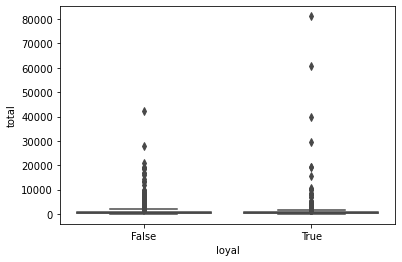

In [31]:
sns.boxplot(x = "loyal", y = "total", data = pivot, palette = 'Set1')

Из-за аномальных чеков графики совсем не наглядные. Отфильтруем данные по 95 перцентилю.

In [32]:
clean_pivot = pivot.copy()
for col in ['total', 'sum_amount', 'cnt_amount']:
    percentiles = np.percentile(pivot[col], 95)
    print(f'95 перцентиль для {col}: {percentiles.round(2)}')
    clean_pivot = clean_pivot[clean_pivot[col] <= percentiles]

95 перцентиль для total: 2433.42
95 перцентиль для sum_amount: 532.0
95 перцентиль для cnt_amount: 57.0


Построим по очищенным данным гистограммы и графики распределения.

In [33]:
loyal = clean_pivot.query('loyal == True')
not_loyal = clean_pivot.query('loyal == False')

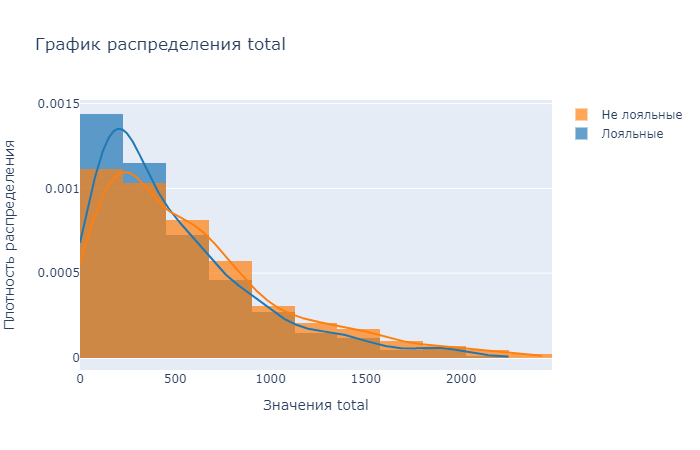

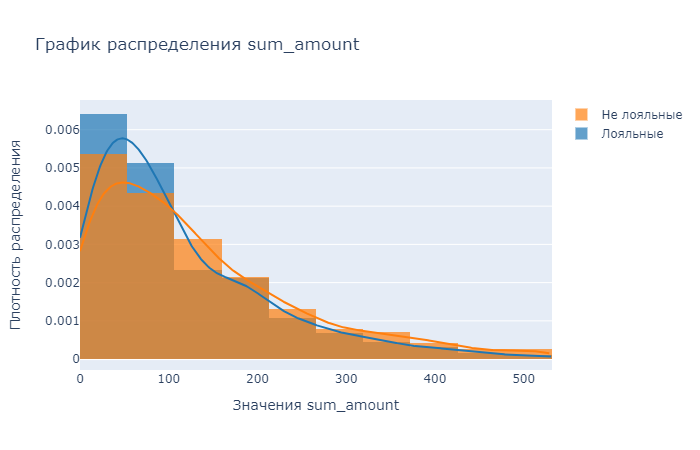

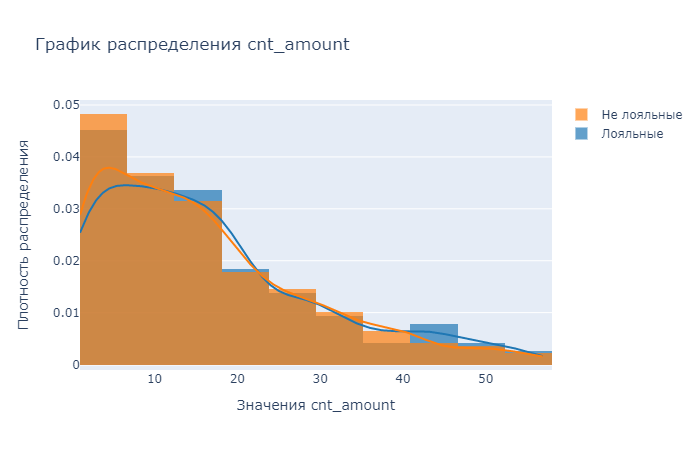

In [34]:
for col in ['total', 'sum_amount', 'cnt_amount']:
    group_labels = ['Лояльные', 'Не лояльные']
    data = [loyal[col], not_loyal[col]]
    fig = ff.create_distplot(data, group_labels, show_rug = False, 
                             bin_size = loyal[col].max() / 10)
    fig.update_layout(
    title = 'График распределения ' + col,
    xaxis_title = "Значения " + col,
    yaxis_title = "Плотность распределения"
    )
    
    fig.show('png')

Распределения похожи на Пуассоновские, а не на нормальные. Учтём это при выборе статистического теста.

Посмотрим так же на "ящики с усами" для тех же величин.

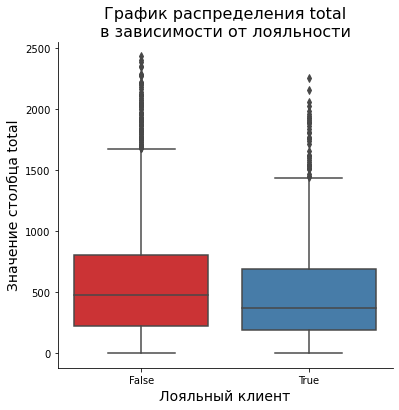

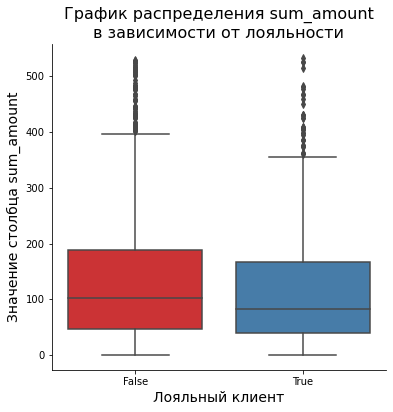

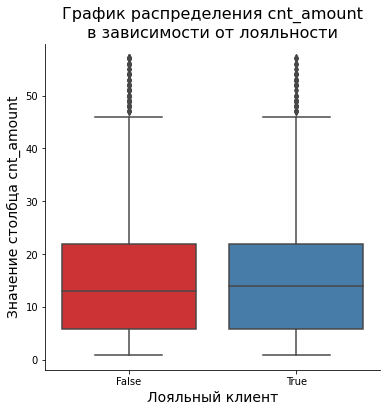

In [35]:
for col in ['total', 'sum_amount', 'cnt_amount']:
    dims = (6, 6)
    fig, ax = plt.subplots(figsize = dims)

    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)

    sns.boxplot(x = 'loyal', y = col, data = clean_pivot, palette = 'Set1')
    

    plt.xlabel('Лояльный клиент', fontsize = 14)
    plt.ylabel('Значение столбца ' + col, fontsize = 14)
    plt.title('График распределения ' + col + '\nв зависимости от лояльности', fontsize = 16)
    
    plt.savefig('Ящик с усами для ' + col + '.png')
plt.show()

Лояльные клиенты проигрывают обычным в среднем чеке и количестве купленных товаров. И находятся примерно на одном уровне по количеству позиций в чеке. Похоже, что программа лояльности не даёт увеличение этих метрик.

**Вывод шага 3:**

В ходе исследовательского анализа данных получили, что:
- Пропущенные значения в идентификаторе клиента относятся к не лояльным. Строки с пропусками пришлось удалить, чтобы не искажать итоговую картину
- Присутствуют аномальные значения количества товаров (отрицательные и превышающие десятки тысяч). Они были удалены (остались значения от 0 до 119 - 99 перцентиля)
- Также было установлено, что в таблице `product_codes` одному товару модет соответствовать несколько разных цен. Есть несколько версий, почему это произошло:
    - какие-то позиции являются стоимостью доставки, которая может различаться
    - какие-то цены могут быть записаны с учётом акций
    - в разных магазинах разная ценовая политика
- За итоговую цену взяли максимальную из списка, так как меньшие цены могут быть с учётом скидок, что исказит средний чек.
- Были проанализированы средний чек, количество товаров и количество позиций в чеке в разбивке по лояльности клиента. По всем метрикам лояльные клиенты не лучше обычных.

Уже можно сказать, что программа лояльности не даёт ожидаемого результата.

### Шаг 4. Проверка гипотез 

Так как мы имеем дело с величинами, распределёнными не нормально, то воспользуемся тестом Манна-Уитни, который не так чувствителен к выбросам.

In [36]:
def test_mw(sample_a, sample_b, parameter):
    '''Функция для проверки гипотез тестом Манна-Уитни

    Принимает на вход 2 набора значений и название параметра, по которому мы проверяем гипотезу
    '''
    pvalue = st.mannwhitneyu(sample_a, sample_b)[1]
    alpha = 0.05

    print('p-значение:', pvalue)

    if (pvalue < alpha):
        print(f"Отвергаем нулевую гипотезу: различия в {parameter} есть")
    else:
        print(f'''Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в {parameter} нет''')

    print("Относительный проигрыш/выигрыш группы не лояльных клиентов равен {0:.1%}".format(sample_b.mean() / sample_a.mean() - 1))

**Нулевая гипотеза:** Средние чеки лояльных и не лояльных клиентов равны. 

**Альтернативная гипотеза:** Средние чеки лояльных и не лояльных клиентов различаются. 

Вероятность ошибки 1-го рода: 5%

In [37]:
test_mw(loyal['total'], not_loyal['total'], 'среднем чеке')

p-значение: 1.0831678910268699e-07
Отвергаем нулевую гипотезу: различия в среднем чеке есть
Относительный проигрыш/выигрыш группы не лояльных клиентов равен 19.4%


**Нулевая гипотеза:** Лояльные и не лояльные клиенты в среднем покупают одинаковое число товаров. 

**Альтернативная гипотеза:** Лояльные и не лояльные клиенты в среднем покупают разное число товаров. 

Вероятность ошибки 1-го рода: 5%

In [38]:
test_mw(loyal['sum_amount'], not_loyal['sum_amount'], 'количестве товаров')

p-значение: 4.564656923135296e-06
Отвергаем нулевую гипотезу: различия в количестве товаров есть
Относительный проигрыш/выигрыш группы не лояльных клиентов равен 17.5%


**Вывод шага 4:**

С помощью теста Манна-Уитни получены статистически значимые различия между группами клиентов. У не лояльных клиентов чек выше на 19 процентов, а количество товаров на 17 процентов. 

### Шаг 5. Вывод и рекомендации 

1. Были проанализированные данные о покупках в магазине строительных материалов. 
2. Данные оптимизированы, приведены к нужным типам, очищены от дубликатов.
3. Проведён исследовательский анализ данных:
    - удалены пропуски в столбце с айди клиента (их было достаточно много и все относились к не лояльным клиентам, так что повлияли бы на дальнейшие результаты)
    - отфильтрованы аномальные значения 
    - для товаров со множеством цен оставлена максимальная (чтобы не искажать средний чек скидочными ценами)
    - по графикам распределения выяснено, что по среднему чеку и количеству товаров в нём лояльные клиенты хуже
        
4. Сформулированы и проверены гипотезы с помощью теста Манна-Уитни:
    - найдены статистически значимые различия между лояльными и обычными клиентами
    - не лояльные клиенты лучше, более чем на 15%, по сравнению с лояльными
    
Клиенты с картой лояльности покупают на меньшие суммы и меньше товаров за раз, чем обычные. Если эти метрики важны, то стоит задуматься об изменениях в программе лояльности. Если важна частота покупок, то нужно провести дополнительное исследование.